In [1]:
import os
import pickle
import numpy as np
import networkx as nx
import statistics as st
import matplotlib.pyplot as plt
import fa2
import powerlaw
import seaborn as sns
from datautils import datautils

In [9]:
def calc_stats(graph_degrees: nx.Graph):
    """
    Calculate mean, median, mode, min and max of given graph degrees
    
    Returns
    -------
    Namespace
        Namespace with statistics
    """
    class Namespace:
        def __init__(self, **kwargs):
            self.__dict__.update(**kwargs)
        
        def __str__(self):
            return str(self.__dict__)

    degrees = [elem[1] for elem in sorted(graph_degrees, key=lambda x: x[1], reverse=True)]    
    return Namespace(
        mean=st.mean(degrees),
        median=st.median(degrees),
        mode=st.mode(degrees),
        min=min(degrees),
        max=max(degrees),
    )

def print_header(title: str):
    """Prints pretty header"""
    print("="*20 + f" {title} " + "="*20 + "\n")
    
def create_directed_graph(data):
    """
    Create directed graph based on data with parameters: Name, Gender, Species, Homeworld, Affiliations, Died
    
    Returns
    -------
    Directed graph
    """
    # initialize universe directional graph
    Universe = nx.DiGraph()
    for _, character in data.iterrows():
        # add node with metadata for each character
        Universe.add_node(character.Name, gender = character.Gender, species = character.Species, home = character.Homeworld, affiliations = character['Affiliation(s)'], died = character.Died)
        for connection in character.Crosslinks:
            if connection in data.Name.values:
                # add edge between character and its connection if it's not a self loop
                if connection != character.Name:
                    Universe.add_edge(character.Name, connection)
    return Universe

def connected_components(graph):
    """
    Extract large connected components
    
    Returns
    -------
    Directed graph
    """
    largest_component = sorted(nx.weakly_connected_components(graph), key=len, reverse=True)[0]
    Undirected_universe_lc = graph.subgraph(largest_component).to_undirected()
    return Undirected_universe_lc

def plot_degree_distribution(graph, scale = None):
    """
    Count the in/out degree distributions and visualize. If scale == log then the y-axis will be in log scale, else normal scale
    
    Returns
    -------
    Subplot showing degree distributions
    """
    in_degrees = [d for _, d in graph.in_degree()]
    out_degrees = [d for _, d in graph.out_degree()]

    fig, ax = plt.subplots(1,2, figsize = (12,8))
    plt.suptitle("Degree distribution")
    ax[0].hist(in_degrees, bins = 100, color = 'cornflowerblue')
    ax[0].set_xlabel("Degree")
    ax[0].set_title("In-degree")
    ax[0].grid('on')
    ax[1].hist(out_degrees, bins = 100, color = 'cornflowerblue')
    if scale == 'log':
        ax[0].set_yscale('log')
        ax[1].set_yscale('log')
        ax[0].set_ylabel("Count (log scale)")
    else:
        ax[0].set_ylabel("Count")
    ax[1].set_title("Out-degree")
    ax[1].set_xlabel("Degree")
    ax[1].grid('on')

def power_law_fit(graph):
    """
    Calculate the best fit power law
    Returns
    -------
    In degree slope
    """
    in_degrees = [degree[1] for degree in graph.in_degree() if degree[1] > 0]
    in_degree_alpha = powerlaw.Fit(in_degrees).alpha
    print(f"In degree slope: {in_degree_alpha:.2f}")

In [3]:
if os.path.exists('data/data_all.pickle'):
    with open('data/data_all.pickle', "rb") as rbfile:
        data = pickle.load(rbfile)
else:
    loader = datautils.Loader()
    loader.load("data/characters/")
    data = loader.to_dataframe()
    loader.drop()
    with open('data/data_all.pickle', "wb") as wbfile:
        pickle.dump(data, wbfile)

All nodes:
Number of nodes: 22967
Number of links: 91910


Connected components:
Number of nodes: 19078
Number of links: 62697
==================== Universe stats ====================

In degree: {'mean': 4.0018287107589146, 'median': 1, 'mode': 1, 'min': 0, 'max': 915}
Out degree: {'mean': 4.0018287107589146, 'median': 2, 'mode': 1, 'min': 0, 'max': 390}
Calculating best minimal value for power law fit
In degree slope: 2.55


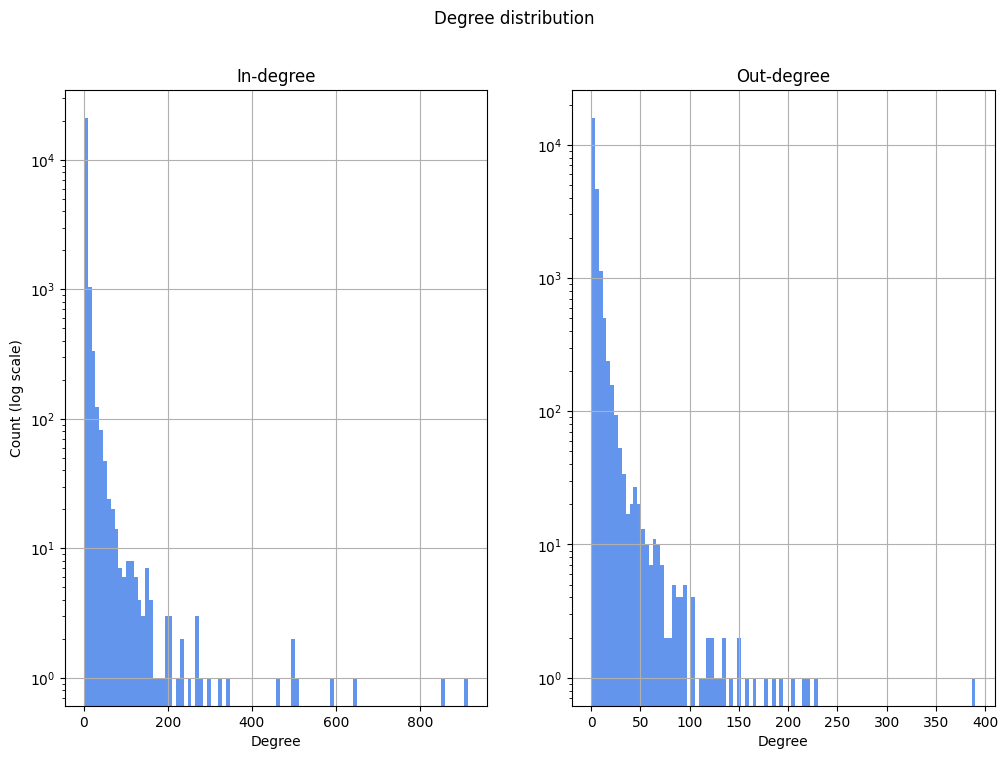

In [11]:
if os.path.exists("graph/universe.edgelist"):
    Universe = nx.read_edgelist("graph/universe.edgelist", create_using=nx.DiGraph)
else:
    Universe = create_directed_graph(data)
    # save graph as an edgelist
    nx.write_edgelist(Universe, "graph/universe.edgelist")

print("All nodes:")
print(f"Number of nodes: {len(Universe.nodes)}")
print(f"Number of links: {len(Universe.edges)}")
print("\n")

Universe_CC = connected_components(Universe)
print("Connected components:")
print(f"Number of nodes: {len(Universe_CC.nodes)}")
print(f"Number of links: {len(Universe_CC.edges)}")

# calculater degree distributions
print_header("Universe stats")
in_stats = calc_stats(Universe.in_degree())
out_stats = calc_stats(Universe.out_degree())
print(f"In degree: {in_stats}")
print(f"Out degree: {out_stats}")

power_law_fit(Universe)    

plot_degree_distribution(Universe, scale = 'log')

In [12]:
def plot_fa2_graph(graph, edge_color, node_color, title, positions_save_name, positions = False):
    """
    Calculate fa2 positions if not present; Display the universe; Save the positions for later use
    """
    if not positions:
        positions = fa2.ForceAtlas2().forceatlas2_networkx_layout(graph, pos=None, iterations=2000)
    # save to pickle for later use
    with open(positions_save_name, "wb") as wbfile:
        pickle.dump(positions, wbfile)

    node_size = [graph.degree(node)//3 for node in graph.nodes]
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    nx.draw_networkx_nodes(graph, positions, node_size=node_size, node_color= node_color, alpha=0.85, ax=ax)
    nx.draw_networkx_edges(graph, positions, edge_color=edge_color, alpha=0.1, ax=ax)
    ax.set_title(title, size=24)
    ax.axis("off")
    plt.show()
    plt.tight_layout()

100%|██████████| 2000/2000 [42:43<00:00,  1.28s/it]


BarnesHut Approximation  took  376.77  seconds
Repulsion forces  took  2144.13  seconds
Gravitational forces  took  4.37  seconds
Attraction forces  took  4.44  seconds
AdjustSpeedAndApplyForces step  took  19.66  seconds


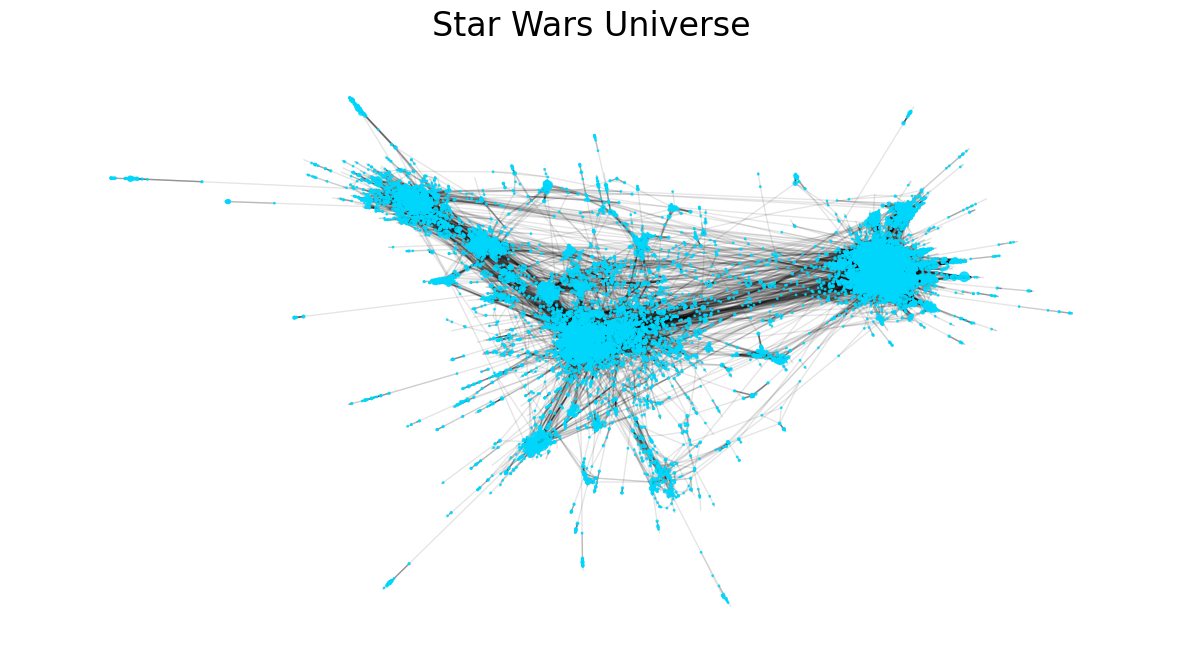

<Figure size 640x480 with 0 Axes>

In [15]:
BLUE = "#00d7fc"
GRAY = "#000000"
FA_POSITIONS = "data/positions.pickle"

# load pickle with pre-calculated positions if present
if os.path.exists(FA_POSITIONS):
    with open(FA_POSITIONS, "rb") as rbfile:
        positions = pickle.load(rbfile)
else:
    positions = None
plot_fa2_graph(Universe_CC, GRAY, BLUE, "Star Wars Universe", FA_POSITIONS, positions = positions)